# 图像分类
[cifar-10](https://www.kaggle.com/c/cifar-10)

In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvisionß
from torch import nn
from d2l import torch as d2l

d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip', '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '/home/jovyan/workspace/pytorch/data/cifar-10'

In [20]:
def read_csv_labels(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [ l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, "trainLabels.csv"))

In [30]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录。"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)
    
def reorg_train_valid(data_dir, labels, valid_ratio):
    """
    改动训练集
    
    每个类别的图像存储在同一文件夹内，文件夹的名字是类别的名字。例如，对于包含猫和狗两个类别的数据集，应该有两个子文件夹，名为"cat"和"dog"，并且所有猫的图片都存储在"cat"文件夹中，所有狗的图片都存储在"dog"文件夹中。
    
    所有文件整理到 train_valid_test 目录下
    train_valid 训练+验证
    valid 验证
    train 训练
    """
    # 获取Label中数量最少的计数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 使用valid_ratio比例计算验证集数量
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        # 用文件名读取文件标签
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(
            fname,
            os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

In [28]:
def reorg_test(data_dir):
    """整理测试集
    test 测试
    Args:
        data_dir (_type_): _description_
    """
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(
            os.path.join(data_dir, 'test', test_file),
            os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

In [31]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

# 图像增广

In [33]:
transform_train = torchvision.transforms.Compose([
    # 将图像的短边调整为40个像素，长边等比例缩放
    torchvision.transforms.Resize(40), 
    # 从图像中随机裁剪一个尺寸为32的区域，且该区域的面积相对于原图像的面积在0.64和1.0之间，切裁区域的宽高比在1.0和1.0之间。
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                             ratio=(1.0, 1.0)),
    # 随机执行水平翻转，有50%的概率对图像进行反转，这是一种常见的数据增强技术。
    torchvision.transforms.RandomHorizontalFlip(),
    # 转换为torch.Tensor，并进行归一化（即将数据调整在0到1之间）。
    torchvision.transforms.ToTensor(),
    # 使用均值[0.4914, 0.4822, 0.4465]和标准差[0.2023, 0.1994, 0.2010]来标准化图像的三个通道。这对于确保模型的稳定和高效训练是必要的。
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

# 设置测试集的图像转换
# 一般情况下，对于测试集的数据转换应与训练集保持一致，以确保信息的同步。然而，一般在测试阶段不会需要对图片进行随机翻转或裁剪等可能会改变数据分布的操作，因为我们希望基于原始数据测试模型的性能。
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

# 读取由原始图像组成的数据集

In [34]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']]

# 指定上面定义的所有图像增广操作

torch.utils.data.DataLoader是一个可以将给定的数据集转换为生成器（需要时生成数据）的类。于是，你可以通过迭代DataLoader对象来获取数据。

dataset, batch_size, shuffle=True, drop_last=True是创建DataLoader对象时传入的参数。
- dataset：传入前面创建的train_ds和train_valid_ds，表示待加载的数据集。
- batch_size：定义了每个批次中样本的数量。
- shuffle=True：在每个训练周期开始时，将数据打乱，这有助于提高模型的泛化能力。
- drop_last=True：当数据集的大小不是批次大小的整数倍时，如果设置为True，那么最后一个不完整的批次将会被舍弃。如果设置为False，最后一个不完整的批次仍然会被使用。舍弃最后的批次可以使数据更整齐，但可能会带来轻微的数据浪费。

In [36]:
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

# 模型

In [38]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

In [39]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # 定义了一个优化器，这个优化器将用于更新模型的权重参数。这里使用的是随机梯度下降（SGD）优化器，它的学习率为lr，正则化参数为wd，动量（用于加速收敛）为0.9。
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    # 学习率调度器，它将在每个lr_period步之后将学习率乘以lr_decay。这用于调整学习率，有助于优化器更好地找到最优解。
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    # 数据并行
    # net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    # 开始循环训练。每次循环称为一个训练周期（epoch）。
    for epoch in range(num_epochs):
        # 将模型设为训练模式。在训练模式下，模型的某些层（例如Dropout层和BatchNorm层）会改变其行为。
        net.train()
        metric = d2l.Accumulator(3)
        # 迭代训练数据。features和labels分别为一批次的特征和标签。
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            # 在一批次的数据上进行训练，并返回计算的损失和准确率。
            l, acc = d2l.train_batch_ch13(net, features, labels, loss,
                                          trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            # 如果提供了验证集，那么在每个周期结束时计算模型在验证集上的准确率。
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        # 学习率调度器，用于根据训练进度调整学习率。
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.142, train acc 0.955, valid acc 0.453
87.3 examples/sec on ['cpu']


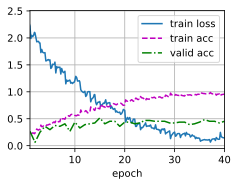

In [43]:
devices, num_epochs, lr, wd = ['cpu'], 40, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

train loss 0.143, train acc 0.966
90.4 examples/sec on ['cpu']


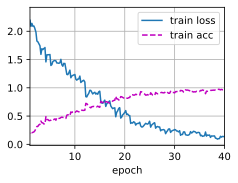

In [44]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)